<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:41] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


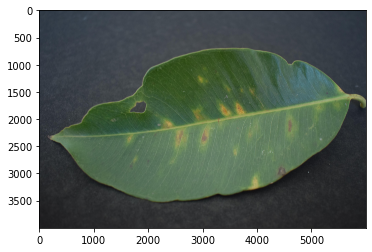

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

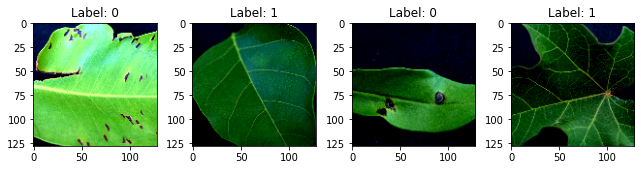

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:46] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:48] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.256427603756728 samples/sec                   batch loss = 0.5523934364318848 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2249559530435459 samples/sec                   batch loss = 0.409431517124176 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2564501863644295 samples/sec                   batch loss = 0.7335108518600464 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2697234086545026 samples/sec                   batch loss = 0.8914136290550232 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2570320624088867 samples/sec                   batch loss = 1.6404123306274414 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2572523009923824 samples/sec                   batch loss = 0.6759892106056213 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2703836324417137 samples/sec                   batch loss = 0.2830287218093872 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.2624728256166486 samples/sec                   batch loss = 0.3293657898902893 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2715933700337574 samples/sec                   batch loss = 0.8339178562164307 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2668710206437588 samples/sec                   batch loss = 0.2746662199497223 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2659420473574092 samples/sec                   batch loss = 0.860241174697876 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.262868530130886 samples/sec                   batch loss = 0.5153115391731262 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2645092027152418 samples/sec                   batch loss = 0.30540743470191956 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.266981616957957 samples/sec                   batch loss = 0.19698671996593475 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2712066275558012 samples/sec                   batch loss = 0.6039422154426575 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2637676740270123 samples/sec                   batch loss = 0.8200977444648743 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2699446566500507 samples/sec                   batch loss = 1.1231458187103271 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.2624100336565605 samples/sec                   batch loss = 0.7012646198272705 | accuracy = 0.6361111111111111


Epoch[1] Batch[95] Speed: 1.2649504367027389 samples/sec                   batch loss = 0.8294837474822998 | accuracy = 0.6342105263157894


Epoch[1] Batch[100] Speed: 1.263962377996655 samples/sec                   batch loss = 0.6758782267570496 | accuracy = 0.645


Epoch[1] Batch[105] Speed: 1.2562790492537865 samples/sec                   batch loss = 1.2739447355270386 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.262618762678141 samples/sec                   batch loss = 0.24150879681110382 | accuracy = 0.65


Epoch[1] Batch[115] Speed: 1.2707500464491526 samples/sec                   batch loss = 0.2838728427886963 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.269015491289955 samples/sec                   batch loss = 0.2415207177400589 | accuracy = 0.6645833333333333


Epoch[1] Batch[125] Speed: 1.264735978361737 samples/sec                   batch loss = 1.0423334836959839 | accuracy = 0.666


Epoch[1] Batch[130] Speed: 1.269837867474896 samples/sec                   batch loss = 0.8684148788452148 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2590562025486687 samples/sec                   batch loss = 0.9300763607025146 | accuracy = 0.6611111111111111


Epoch[1] Batch[140] Speed: 1.2563467834918591 samples/sec                   batch loss = 0.6098753213882446 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.2669191410614784 samples/sec                   batch loss = 0.23563389480113983 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2596385093496003 samples/sec                   batch loss = 0.7544888854026794 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.2611092431870947 samples/sec                   batch loss = 0.37313881516456604 | accuracy = 0.6612903225806451


Epoch[1] Batch[160] Speed: 1.2643972270890584 samples/sec                   batch loss = 0.9008849859237671 | accuracy = 0.6578125


Epoch[1] Batch[165] Speed: 1.2642993718675044 samples/sec                   batch loss = 0.8801130652427673 | accuracy = 0.6590909090909091


Epoch[1] Batch[170] Speed: 1.2603724530316913 samples/sec                   batch loss = 0.5758359432220459 | accuracy = 0.6602941176470588


Epoch[1] Batch[175] Speed: 1.2588496886643759 samples/sec                   batch loss = 0.4791747033596039 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.2617971665170258 samples/sec                   batch loss = 0.30992162227630615 | accuracy = 0.6666666666666666


Epoch[1] Batch[185] Speed: 1.2610887677952578 samples/sec                   batch loss = 0.6976131200790405 | accuracy = 0.668918918918919


Epoch[1] Batch[190] Speed: 1.2646580895353132 samples/sec                   batch loss = 0.916845977306366 | accuracy = 0.6644736842105263


Epoch[1] Batch[195] Speed: 1.2577862617052384 samples/sec                   batch loss = 0.44247967004776 | accuracy = 0.6653846153846154


Epoch[1] Batch[200] Speed: 1.2548123269344986 samples/sec                   batch loss = 0.37586963176727295 | accuracy = 0.66625


Epoch[1] Batch[205] Speed: 1.253222635044261 samples/sec                   batch loss = 0.516434371471405 | accuracy = 0.6695121951219513


Epoch[1] Batch[210] Speed: 1.2623709936959764 samples/sec                   batch loss = 0.8830621242523193 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.2583825900356014 samples/sec                   batch loss = 1.0512888431549072 | accuracy = 0.6697674418604651


Epoch[1] Batch[220] Speed: 1.2536282982041222 samples/sec                   batch loss = 0.6797940731048584 | accuracy = 0.6670454545454545


Epoch[1] Batch[225] Speed: 1.2646293007452074 samples/sec                   batch loss = 0.5950680375099182 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.2604411028781517 samples/sec                   batch loss = 0.3159720301628113 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.2571564905516281 samples/sec                   batch loss = 0.13553209602832794 | accuracy = 0.675531914893617


Epoch[1] Batch[240] Speed: 1.2630544942614836 samples/sec                   batch loss = 0.5733020901679993 | accuracy = 0.6760416666666667


Epoch[1] Batch[245] Speed: 1.2656506738973112 samples/sec                   batch loss = 0.4213032126426697 | accuracy = 0.6795918367346939


Epoch[1] Batch[250] Speed: 1.2591127080863909 samples/sec                   batch loss = 0.3558003008365631 | accuracy = 0.685


Epoch[1] Batch[255] Speed: 1.2720780454606042 samples/sec                   batch loss = 0.5066179633140564 | accuracy = 0.6833333333333333


Epoch[1] Batch[260] Speed: 1.2658782412388652 samples/sec                   batch loss = 0.3930710256099701 | accuracy = 0.6807692307692308


Epoch[1] Batch[265] Speed: 1.2599107522765138 samples/sec                   batch loss = 0.6550272107124329 | accuracy = 0.6792452830188679


Epoch[1] Batch[270] Speed: 1.264508440260942 samples/sec                   batch loss = 0.22718296945095062 | accuracy = 0.6814814814814815


Epoch[1] Batch[275] Speed: 1.2650167246675312 samples/sec                   batch loss = 0.5281262993812561 | accuracy = 0.6818181818181818


Epoch[1] Batch[280] Speed: 1.2658630548020275 samples/sec                   batch loss = 0.5151697397232056 | accuracy = 0.6839285714285714


Epoch[1] Batch[285] Speed: 1.2623870463314988 samples/sec                   batch loss = 0.38432255387306213 | accuracy = 0.6833333333333333


Epoch[1] Batch[290] Speed: 1.263139698575999 samples/sec                   batch loss = 0.8296667337417603 | accuracy = 0.6836206896551724


Epoch[1] Batch[295] Speed: 1.261007346774585 samples/sec                   batch loss = 0.5316125750541687 | accuracy = 0.6838983050847458


Epoch[1] Batch[300] Speed: 1.2570646505937995 samples/sec                   batch loss = 0.4361361563205719 | accuracy = 0.6825


Epoch[1] Batch[305] Speed: 1.2644081855301625 samples/sec                   batch loss = 0.27752038836479187 | accuracy = 0.6860655737704918


Epoch[1] Batch[310] Speed: 1.261630451939432 samples/sec                   batch loss = 0.48268282413482666 | accuracy = 0.6862903225806452


Epoch[1] Batch[315] Speed: 1.259861932864799 samples/sec                   batch loss = 0.28942182660102844 | accuracy = 0.6880952380952381


Epoch[1] Batch[320] Speed: 1.2680432131349355 samples/sec                   batch loss = 0.5029526948928833 | accuracy = 0.6890625


Epoch[1] Batch[325] Speed: 1.2598826522692803 samples/sec                   batch loss = 0.7983359098434448 | accuracy = 0.6907692307692308


Epoch[1] Batch[330] Speed: 1.263471686609436 samples/sec                   batch loss = 0.36476588249206543 | accuracy = 0.6916666666666667


Epoch[1] Batch[335] Speed: 1.2636763885215945 samples/sec                   batch loss = 0.3881407678127289 | accuracy = 0.6925373134328359


Epoch[1] Batch[340] Speed: 1.2626777741543567 samples/sec                   batch loss = 1.0357507467269897 | accuracy = 0.6933823529411764


Epoch[1] Batch[345] Speed: 1.2610241230049795 samples/sec                   batch loss = 1.3845137357711792 | accuracy = 0.6927536231884058


Epoch[1] Batch[350] Speed: 1.2616092006574993 samples/sec                   batch loss = 0.5212564468383789 | accuracy = 0.6928571428571428


Epoch[1] Batch[355] Speed: 1.2636204243682412 samples/sec                   batch loss = 0.3350121080875397 | accuracy = 0.6922535211267605


Epoch[1] Batch[360] Speed: 1.2549372546931072 samples/sec                   batch loss = 0.38682615756988525 | accuracy = 0.6951388888888889


Epoch[1] Batch[365] Speed: 1.265309905679552 samples/sec                   batch loss = 1.0723707675933838 | accuracy = 0.6924657534246575


Epoch[1] Batch[370] Speed: 1.2582333841759972 samples/sec                   batch loss = 0.5955893993377686 | accuracy = 0.6905405405405406


Epoch[1] Batch[375] Speed: 1.2559107781089418 samples/sec                   batch loss = 0.38396579027175903 | accuracy = 0.6893333333333334


Epoch[1] Batch[380] Speed: 1.2647321647319385 samples/sec                   batch loss = 0.5200408697128296 | accuracy = 0.6901315789473684


Epoch[1] Batch[385] Speed: 1.2688553086431704 samples/sec                   batch loss = 0.4718533754348755 | accuracy = 0.688961038961039


Epoch[1] Batch[390] Speed: 1.255003905520076 samples/sec                   batch loss = 0.781320333480835 | accuracy = 0.6891025641025641


Epoch[1] Batch[395] Speed: 1.2621482936316308 samples/sec                   batch loss = 1.5374265909194946 | accuracy = 0.6905063291139241


Epoch[1] Batch[400] Speed: 1.2723924576015577 samples/sec                   batch loss = 0.9843062162399292 | accuracy = 0.691875


Epoch[1] Batch[405] Speed: 1.2595555733734416 samples/sec                   batch loss = 0.2665034532546997 | accuracy = 0.6919753086419753


Epoch[1] Batch[410] Speed: 1.265012718578897 samples/sec                   batch loss = 1.0893347263336182 | accuracy = 0.6926829268292682


Epoch[1] Batch[415] Speed: 1.266582566123486 samples/sec                   batch loss = 0.6065638661384583 | accuracy = 0.6903614457831325


Epoch[1] Batch[420] Speed: 1.2613425768948954 samples/sec                   batch loss = 0.6354339718818665 | accuracy = 0.6898809523809524


Epoch[1] Batch[425] Speed: 1.2616990491317048 samples/sec                   batch loss = 0.4887782335281372 | accuracy = 0.6911764705882353


Epoch[1] Batch[430] Speed: 1.2631463556472011 samples/sec                   batch loss = 0.39107251167297363 | accuracy = 0.6924418604651162


Epoch[1] Batch[435] Speed: 1.257503059957172 samples/sec                   batch loss = 0.5755923390388489 | accuracy = 0.6908045977011494


Epoch[1] Batch[440] Speed: 1.261568597520283 samples/sec                   batch loss = 0.9185625910758972 | accuracy = 0.6926136363636364


Epoch[1] Batch[445] Speed: 1.2696238625975458 samples/sec                   batch loss = 0.6389948129653931 | accuracy = 0.6932584269662921


Epoch[1] Batch[450] Speed: 1.266462957246914 samples/sec                   batch loss = 1.1844669580459595 | accuracy = 0.6911111111111111


Epoch[1] Batch[455] Speed: 1.2525778791487328 samples/sec                   batch loss = 0.48329347372055054 | accuracy = 0.6901098901098901


Epoch[1] Batch[460] Speed: 1.2654867577043067 samples/sec                   batch loss = 0.27282869815826416 | accuracy = 0.6918478260869565


Epoch[1] Batch[465] Speed: 1.2677582481056413 samples/sec                   batch loss = 0.3909980058670044 | accuracy = 0.6935483870967742


Epoch[1] Batch[470] Speed: 1.2588188024305687 samples/sec                   batch loss = 0.3361567258834839 | accuracy = 0.6957446808510638


Epoch[1] Batch[475] Speed: 1.2647054699673066 samples/sec                   batch loss = 0.39991503953933716 | accuracy = 0.6973684210526315


Epoch[1] Batch[480] Speed: 1.2693439489684453 samples/sec                   batch loss = 0.7107958793640137 | accuracy = 0.6979166666666666


Epoch[1] Batch[485] Speed: 1.2581414811637415 samples/sec                   batch loss = 0.39824509620666504 | accuracy = 0.6979381443298969


Epoch[1] Batch[490] Speed: 1.2652419648893654 samples/sec                   batch loss = 0.22708390653133392 | accuracy = 0.6979591836734694


Epoch[1] Batch[495] Speed: 1.2622300519887335 samples/sec                   batch loss = 0.21632617712020874 | accuracy = 0.6974747474747475


Epoch[1] Batch[500] Speed: 1.261234859099395 samples/sec                   batch loss = 0.5075812935829163 | accuracy = 0.697


Epoch[1] Batch[505] Speed: 1.2619821507458402 samples/sec                   batch loss = 0.15627101063728333 | accuracy = 0.699009900990099


Epoch[1] Batch[510] Speed: 1.268344702576354 samples/sec                   batch loss = 0.5446638464927673 | accuracy = 0.7


Epoch[1] Batch[515] Speed: 1.2647881320570473 samples/sec                   batch loss = 0.5684654712677002 | accuracy = 0.6985436893203884


Epoch[1] Batch[520] Speed: 1.2627273822712106 samples/sec                   batch loss = 0.20521663129329681 | accuracy = 0.7009615384615384


Epoch[1] Batch[525] Speed: 1.264479753586013 samples/sec                   batch loss = 0.48334699869155884 | accuracy = 0.700952380952381


Epoch[1] Batch[530] Speed: 1.258360881733826 samples/sec                   batch loss = 1.1617075204849243 | accuracy = 0.7009433962264151


Epoch[1] Batch[535] Speed: 1.2590016861265234 samples/sec                   batch loss = 0.2535557746887207 | accuracy = 0.7023364485981308


Epoch[1] Batch[540] Speed: 1.2651259480498935 samples/sec                   batch loss = 0.6078007221221924 | accuracy = 0.700925925925926


Epoch[1] Batch[545] Speed: 1.2563069887419809 samples/sec                   batch loss = 0.16139008104801178 | accuracy = 0.7009174311926606


Epoch[1] Batch[550] Speed: 1.2623572210500718 samples/sec                   batch loss = 0.7681643962860107 | accuracy = 0.7


Epoch[1] Batch[555] Speed: 1.266491447159784 samples/sec                   batch loss = 0.4435584247112274 | accuracy = 0.7013513513513514


Epoch[1] Batch[560] Speed: 1.2635881615733153 samples/sec                   batch loss = 0.23743478953838348 | accuracy = 0.7026785714285714


Epoch[1] Batch[565] Speed: 1.260589033204451 samples/sec                   batch loss = 0.6874693632125854 | accuracy = 0.7035398230088495


Epoch[1] Batch[570] Speed: 1.271019892262053 samples/sec                   batch loss = 0.5010548233985901 | accuracy = 0.7035087719298245


Epoch[1] Batch[575] Speed: 1.27015367321563 samples/sec                   batch loss = 0.7416741847991943 | accuracy = 0.7021739130434783


Epoch[1] Batch[580] Speed: 1.2614796212797752 samples/sec                   batch loss = 0.7829942107200623 | accuracy = 0.7030172413793103


Epoch[1] Batch[585] Speed: 1.2652245991728523 samples/sec                   batch loss = 0.5166832208633423 | accuracy = 0.7029914529914529


Epoch[1] Batch[590] Speed: 1.2700619435838436 samples/sec                   batch loss = 0.60252445936203 | accuracy = 0.7033898305084746


Epoch[1] Batch[595] Speed: 1.2529759195273749 samples/sec                   batch loss = 0.4213281273841858 | accuracy = 0.7046218487394958


Epoch[1] Batch[600] Speed: 1.2630751286265514 samples/sec                   batch loss = 0.6045420169830322 | accuracy = 0.70375


Epoch[1] Batch[605] Speed: 1.2690176990025892 samples/sec                   batch loss = 0.18163152039051056 | accuracy = 0.7020661157024793


Epoch[1] Batch[610] Speed: 1.2581212907196884 samples/sec                   batch loss = 0.6679127216339111 | accuracy = 0.7020491803278689


Epoch[1] Batch[615] Speed: 1.2610287673510423 samples/sec                   batch loss = 0.3962748050689697 | accuracy = 0.7020325203252032


Epoch[1] Batch[620] Speed: 1.2564129254970282 samples/sec                   batch loss = 0.8047290444374084 | accuracy = 0.7012096774193548


Epoch[1] Batch[625] Speed: 1.2539140681188623 samples/sec                   batch loss = 0.6098182797431946 | accuracy = 0.7012


Epoch[1] Batch[630] Speed: 1.2547115393460342 samples/sec                   batch loss = 0.2755766808986664 | accuracy = 0.7011904761904761


Epoch[1] Batch[635] Speed: 1.261098626234257 samples/sec                   batch loss = 0.5296880006790161 | accuracy = 0.7023622047244095


Epoch[1] Batch[640] Speed: 1.2544375990566379 samples/sec                   batch loss = 0.24572448432445526 | accuracy = 0.703515625


Epoch[1] Batch[645] Speed: 1.2448285042098213 samples/sec                   batch loss = 0.4815635681152344 | accuracy = 0.703875968992248


Epoch[1] Batch[650] Speed: 1.254978652472333 samples/sec                   batch loss = 0.47685912251472473 | accuracy = 0.705


Epoch[1] Batch[655] Speed: 1.2590647064023783 samples/sec                   batch loss = 0.7055457830429077 | accuracy = 0.7045801526717558


Epoch[1] Batch[660] Speed: 1.2496589310023154 samples/sec                   batch loss = 0.5208204984664917 | accuracy = 0.7045454545454546


Epoch[1] Batch[665] Speed: 1.2572119778079502 samples/sec                   batch loss = 1.017376184463501 | accuracy = 0.705639097744361


Epoch[1] Batch[670] Speed: 1.2617995389831773 samples/sec                   batch loss = 0.5538967847824097 | accuracy = 0.7055970149253732


Epoch[1] Batch[675] Speed: 1.250397130317026 samples/sec                   batch loss = 0.5358269214630127 | accuracy = 0.705925925925926


Epoch[1] Batch[680] Speed: 1.2623038430137683 samples/sec                   batch loss = 0.4410639703273773 | accuracy = 0.705514705882353


Epoch[1] Batch[685] Speed: 1.2586571230921109 samples/sec                   batch loss = 0.8375079035758972 | accuracy = 0.7062043795620438


Epoch[1] Batch[690] Speed: 1.2494499981046616 samples/sec                   batch loss = 0.2538658380508423 | accuracy = 0.7065217391304348


Epoch[1] Batch[695] Speed: 1.2539434957629034 samples/sec                   batch loss = 0.4433509409427643 | accuracy = 0.706115107913669


Epoch[1] Batch[700] Speed: 1.2629894576329217 samples/sec                   batch loss = 1.020093560218811 | accuracy = 0.7067857142857142


Epoch[1] Batch[705] Speed: 1.2673017471044563 samples/sec                   batch loss = 0.16820938885211945 | accuracy = 0.7070921985815602


Epoch[1] Batch[710] Speed: 1.272273968011181 samples/sec                   batch loss = 0.7573447227478027 | accuracy = 0.7070422535211267


Epoch[1] Batch[715] Speed: 1.2726498721829036 samples/sec                   batch loss = 0.22477227449417114 | accuracy = 0.7073426573426573


Epoch[1] Batch[720] Speed: 1.267740717453271 samples/sec                   batch loss = 0.7824347615242004 | accuracy = 0.7072916666666667


Epoch[1] Batch[725] Speed: 1.264159999590097 samples/sec                   batch loss = 0.8191014528274536 | accuracy = 0.7075862068965517


Epoch[1] Batch[730] Speed: 1.2629451528883937 samples/sec                   batch loss = 0.527643084526062 | accuracy = 0.7078767123287671


Epoch[1] Batch[735] Speed: 1.2601752565216442 samples/sec                   batch loss = 0.6268940567970276 | accuracy = 0.7085034013605442


Epoch[1] Batch[740] Speed: 1.2630629571222862 samples/sec                   batch loss = 2.817479372024536 | accuracy = 0.7087837837837838


Epoch[1] Batch[745] Speed: 1.2602487128194046 samples/sec                   batch loss = 0.4923206567764282 | accuracy = 0.7090604026845637


Epoch[1] Batch[750] Speed: 1.2638656373768553 samples/sec                   batch loss = 0.4865586757659912 | accuracy = 0.7096666666666667


Epoch[1] Batch[755] Speed: 1.2670670648747053 samples/sec                   batch loss = 0.40251871943473816 | accuracy = 0.7096026490066225


Epoch[1] Batch[760] Speed: 1.259066785139646 samples/sec                   batch loss = 0.6915231347084045 | accuracy = 0.7105263157894737


Epoch[1] Batch[765] Speed: 1.2683902500096014 samples/sec                   batch loss = 0.3767574727535248 | accuracy = 0.7107843137254902


Epoch[1] Batch[770] Speed: 1.2612187409414732 samples/sec                   batch loss = 0.18597565591335297 | accuracy = 0.7116883116883117


Epoch[1] Batch[775] Speed: 1.265469576170829 samples/sec                   batch loss = 0.5589385032653809 | accuracy = 0.7119354838709677


Epoch[1] Batch[780] Speed: 1.2627304235086263 samples/sec                   batch loss = 0.4333590865135193 | accuracy = 0.7121794871794872


Epoch[1] Batch[785] Speed: 1.2605614712096487 samples/sec                   batch loss = 1.0201091766357422 | accuracy = 0.7111464968152866


[Epoch 1] training: accuracy=0.7109771573604061
[Epoch 1] time cost: 648.4676587581635
[Epoch 1] validation: validation accuracy=0.66


Epoch[2] Batch[5] Speed: 1.2949053612883776 samples/sec                   batch loss = 0.4122045040130615 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2937533346859078 samples/sec                   batch loss = 0.4964202046394348 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2944128254237088 samples/sec                   batch loss = 0.11347239464521408 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2880363713387843 samples/sec                   batch loss = 0.52179354429245 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2692265065430859 samples/sec                   batch loss = 0.4261818528175354 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2692004858561277 samples/sec                   batch loss = 0.287820965051651 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.2692488794258594 samples/sec                   batch loss = 0.4896102845668793 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2715633008985412 samples/sec                   batch loss = 1.304247260093689 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2605915905640408 samples/sec                   batch loss = 0.8298799395561218 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.26847454536203 samples/sec                   batch loss = 0.33053603768348694 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2676331492567627 samples/sec                   batch loss = 0.6653550863265991 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2626528765303646 samples/sec                   batch loss = 0.23422914743423462 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2651715508155112 samples/sec                   batch loss = 0.5467914938926697 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2629008512521127 samples/sec                   batch loss = 0.3584533929824829 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2597255234810356 samples/sec                   batch loss = 0.7333848476409912 | accuracy = 0.7266666666666667


Epoch[2] Batch[80] Speed: 1.2678517531072435 samples/sec                   batch loss = 0.4112556576728821 | accuracy = 0.725


Epoch[2] Batch[85] Speed: 1.2693640210259116 samples/sec                   batch loss = 0.4733411371707916 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2695206817140676 samples/sec                   batch loss = 0.22272835671901703 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.2674695809705987 samples/sec                   batch loss = 0.5705817937850952 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.263476824758013 samples/sec                   batch loss = 0.366105854511261 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2634049896211152 samples/sec                   batch loss = 0.4796464741230011 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2660935648983644 samples/sec                   batch loss = 0.34212422370910645 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.258014688371496 samples/sec                   batch loss = 0.44136419892311096 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2596954454978688 samples/sec                   batch loss = 0.42644715309143066 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.2686283005499561 samples/sec                   batch loss = 0.2909533381462097 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2648140674885 samples/sec                   batch loss = 0.3438660204410553 | accuracy = 0.7461538461538462


Epoch[2] Batch[135] Speed: 1.267076921310831 samples/sec                   batch loss = 0.38694900274276733 | accuracy = 0.7481481481481481


Epoch[2] Batch[140] Speed: 1.2670480222916622 samples/sec                   batch loss = 0.8874791860580444 | accuracy = 0.75


Epoch[2] Batch[145] Speed: 1.2673364974161836 samples/sec                   batch loss = 0.31154975295066833 | accuracy = 0.75


Epoch[2] Batch[150] Speed: 1.257957904053321 samples/sec                   batch loss = 1.0036481618881226 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2648415296929356 samples/sec                   batch loss = 0.5233933329582214 | accuracy = 0.7483870967741936


Epoch[2] Batch[160] Speed: 1.2608427359236203 samples/sec                   batch loss = 0.4016049802303314 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2625564312639173 samples/sec                   batch loss = 0.4950205683708191 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2608458628450034 samples/sec                   batch loss = 0.2622474431991577 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.2703446748960499 samples/sec                   batch loss = 1.0102834701538086 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.2708785530851037 samples/sec                   batch loss = 0.566123902797699 | accuracy = 0.7402777777777778


Epoch[2] Batch[185] Speed: 1.2773587816086458 samples/sec                   batch loss = 0.5517666339874268 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2714716566341668 samples/sec                   batch loss = 0.2560746669769287 | accuracy = 0.7368421052631579


Epoch[2] Batch[195] Speed: 1.2654880940653543 samples/sec                   batch loss = 0.1668892651796341 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.275176448948755 samples/sec                   batch loss = 1.1487700939178467 | accuracy = 0.7425


Epoch[2] Batch[205] Speed: 1.2764327234578716 samples/sec                   batch loss = 0.4879530072212219 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.2663628702989989 samples/sec                   batch loss = 0.4441588819026947 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.264847441851278 samples/sec                   batch loss = 0.5520579814910889 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.2675061599084585 samples/sec                   batch loss = 0.8150346875190735 | accuracy = 0.7454545454545455


Epoch[2] Batch[225] Speed: 1.270059828381751 samples/sec                   batch loss = 0.4009188115596771 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.2658378403908965 samples/sec                   batch loss = 0.7038672566413879 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2671879364234384 samples/sec                   batch loss = 0.3326936662197113 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2670470653930455 samples/sec                   batch loss = 0.47552621364593506 | accuracy = 0.75


Epoch[2] Batch[245] Speed: 1.2723878256721435 samples/sec                   batch loss = 0.2262764424085617 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2701518461858876 samples/sec                   batch loss = 0.25440514087677 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2606935145266063 samples/sec                   batch loss = 0.4319078326225281 | accuracy = 0.7519607843137255


Epoch[2] Batch[260] Speed: 1.2646982244399239 samples/sec                   batch loss = 0.3842305541038513 | accuracy = 0.7538461538461538


Epoch[2] Batch[265] Speed: 1.2648704235078763 samples/sec                   batch loss = 0.5442988872528076 | accuracy = 0.7556603773584906


Epoch[2] Batch[270] Speed: 1.2661444928706425 samples/sec                   batch loss = 0.3528812527656555 | accuracy = 0.7555555555555555


Epoch[2] Batch[275] Speed: 1.2663639217510847 samples/sec                   batch loss = 0.45371633768081665 | accuracy = 0.7554545454545455


Epoch[2] Batch[280] Speed: 1.2674180676176248 samples/sec                   batch loss = 0.5519334673881531 | accuracy = 0.7544642857142857


Epoch[2] Batch[285] Speed: 1.2735625200165819 samples/sec                   batch loss = 0.3774440884590149 | accuracy = 0.756140350877193


Epoch[2] Batch[290] Speed: 1.2684299508617305 samples/sec                   batch loss = 0.3430905044078827 | accuracy = 0.7586206896551724


Epoch[2] Batch[295] Speed: 1.2743950613326536 samples/sec                   batch loss = 0.40799492597579956 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.2715155979767572 samples/sec                   batch loss = 0.2712612748146057 | accuracy = 0.7583333333333333


Epoch[2] Batch[305] Speed: 1.2718113173906531 samples/sec                   batch loss = 0.39307117462158203 | accuracy = 0.7573770491803279


Epoch[2] Batch[310] Speed: 1.2764510780193192 samples/sec                   batch loss = 0.33568471670150757 | accuracy = 0.7612903225806451


Epoch[2] Batch[315] Speed: 1.2757296266655007 samples/sec                   batch loss = 0.31601569056510925 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2738022260160866 samples/sec                   batch loss = 0.3388478755950928 | accuracy = 0.76171875


Epoch[2] Batch[325] Speed: 1.270578071121163 samples/sec                   batch loss = 0.17675715684890747 | accuracy = 0.7638461538461538


Epoch[2] Batch[330] Speed: 1.2608258697666386 samples/sec                   batch loss = 0.3046494126319885 | accuracy = 0.7636363636363637


Epoch[2] Batch[335] Speed: 1.2663849511594742 samples/sec                   batch loss = 0.8092131614685059 | accuracy = 0.7656716417910447


Epoch[2] Batch[340] Speed: 1.2615197444058708 samples/sec                   batch loss = 0.16510510444641113 | accuracy = 0.7676470588235295


Epoch[2] Batch[345] Speed: 1.2710437728293629 samples/sec                   batch loss = 0.3322980999946594 | accuracy = 0.7666666666666667


Epoch[2] Batch[350] Speed: 1.269036512865385 samples/sec                   batch loss = 0.36885732412338257 | accuracy = 0.7642857142857142


Epoch[2] Batch[355] Speed: 1.2715217654257849 samples/sec                   batch loss = 0.4195331335067749 | accuracy = 0.7676056338028169


Epoch[2] Batch[360] Speed: 1.2702369528878912 samples/sec                   batch loss = 0.34618449211120605 | accuracy = 0.7680555555555556


Epoch[2] Batch[365] Speed: 1.2678616217552792 samples/sec                   batch loss = 0.5188862681388855 | accuracy = 0.7678082191780822


Epoch[2] Batch[370] Speed: 1.264302230130488 samples/sec                   batch loss = 0.12183845043182373 | accuracy = 0.7682432432432432


Epoch[2] Batch[375] Speed: 1.2721494233507424 samples/sec                   batch loss = 0.18010498583316803 | accuracy = 0.77


Epoch[2] Batch[380] Speed: 1.2728106281391691 samples/sec                   batch loss = 0.3774659037590027 | accuracy = 0.7703947368421052


Epoch[2] Batch[385] Speed: 1.2715591568664069 samples/sec                   batch loss = 0.8646373748779297 | accuracy = 0.7701298701298701


Epoch[2] Batch[390] Speed: 1.263634319766844 samples/sec                   batch loss = 1.154110074043274 | accuracy = 0.7673076923076924


Epoch[2] Batch[395] Speed: 1.2654807441145193 samples/sec                   batch loss = 1.9037925004959106 | accuracy = 0.7670886075949367


Epoch[2] Batch[400] Speed: 1.2688307425631005 samples/sec                   batch loss = 0.569720447063446 | accuracy = 0.76625


Epoch[2] Batch[405] Speed: 1.282493421926189 samples/sec                   batch loss = 0.4947669208049774 | accuracy = 0.7672839506172839


Epoch[2] Batch[410] Speed: 1.2924776871934576 samples/sec                   batch loss = 0.4535353481769562 | accuracy = 0.7670731707317073


Epoch[2] Batch[415] Speed: 1.29125911112151 samples/sec                   batch loss = 0.5759612917900085 | accuracy = 0.7656626506024097


Epoch[2] Batch[420] Speed: 1.2935333877971957 samples/sec                   batch loss = 0.31964513659477234 | accuracy = 0.7666666666666667


Epoch[2] Batch[425] Speed: 1.2961912154488984 samples/sec                   batch loss = 0.41395723819732666 | accuracy = 0.7647058823529411


Epoch[2] Batch[430] Speed: 1.28724813646051 samples/sec                   batch loss = 0.26234784722328186 | accuracy = 0.7651162790697674


Epoch[2] Batch[435] Speed: 1.293041894881217 samples/sec                   batch loss = 0.6766263246536255 | accuracy = 0.7649425287356322


Epoch[2] Batch[440] Speed: 1.2925107451043232 samples/sec                   batch loss = 0.6059431433677673 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.294123572901369 samples/sec                   batch loss = 0.28744739294052124 | accuracy = 0.7651685393258427


Epoch[2] Batch[450] Speed: 1.2945551527639518 samples/sec                   batch loss = 0.25656166672706604 | accuracy = 0.7661111111111111


Epoch[2] Batch[455] Speed: 1.2891291018089222 samples/sec                   batch loss = 0.44866758584976196 | accuracy = 0.7653846153846153


Epoch[2] Batch[460] Speed: 1.2935952247158091 samples/sec                   batch loss = 0.47993263602256775 | accuracy = 0.7635869565217391


Epoch[2] Batch[465] Speed: 1.2951500701179985 samples/sec                   batch loss = 0.5307851433753967 | accuracy = 0.763978494623656


Epoch[2] Batch[470] Speed: 1.2933710441564465 samples/sec                   batch loss = 0.47443902492523193 | accuracy = 0.7638297872340426


Epoch[2] Batch[475] Speed: 1.2976060686685187 samples/sec                   batch loss = 0.5632802248001099 | accuracy = 0.7647368421052632


Epoch[2] Batch[480] Speed: 1.2936431025197996 samples/sec                   batch loss = 0.67525714635849 | accuracy = 0.7645833333333333


Epoch[2] Batch[485] Speed: 1.2948671838556522 samples/sec                   batch loss = 0.24942705035209656 | accuracy = 0.7644329896907216


Epoch[2] Batch[490] Speed: 1.2978572209890447 samples/sec                   batch loss = 0.38012415170669556 | accuracy = 0.7627551020408163


Epoch[2] Batch[495] Speed: 1.2915424114219007 samples/sec                   batch loss = 0.3526380956172943 | accuracy = 0.7616161616161616


Epoch[2] Batch[500] Speed: 1.2952288604495144 samples/sec                   batch loss = 0.5623172521591187 | accuracy = 0.7615


Epoch[2] Batch[505] Speed: 1.2960497295997817 samples/sec                   batch loss = 0.26049429178237915 | accuracy = 0.7628712871287129


Epoch[2] Batch[510] Speed: 1.2986934895244306 samples/sec                   batch loss = 0.2061341255903244 | accuracy = 0.7627450980392156


Epoch[2] Batch[515] Speed: 1.2967077557305173 samples/sec                   batch loss = 0.3549310266971588 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.294526884562898 samples/sec                   batch loss = 0.20282837748527527 | accuracy = 0.7639423076923076


Epoch[2] Batch[525] Speed: 1.2911886532630126 samples/sec                   batch loss = 0.3936789333820343 | accuracy = 0.7642857142857142


Epoch[2] Batch[530] Speed: 1.3013130317566088 samples/sec                   batch loss = 0.51857590675354 | accuracy = 0.7641509433962265


Epoch[2] Batch[535] Speed: 1.297348893896136 samples/sec                   batch loss = 0.3530009984970093 | accuracy = 0.7630841121495328


Epoch[2] Batch[540] Speed: 1.2931959820716954 samples/sec                   batch loss = 0.12460392713546753 | accuracy = 0.7638888888888888


Epoch[2] Batch[545] Speed: 1.2980672918952652 samples/sec                   batch loss = 0.3448861837387085 | accuracy = 0.7651376146788991


Epoch[2] Batch[550] Speed: 1.2917112578612673 samples/sec                   batch loss = 0.7068020105361938 | accuracy = 0.7636363636363637


Epoch[2] Batch[555] Speed: 1.2940986175761429 samples/sec                   batch loss = 0.4663713276386261 | accuracy = 0.7626126126126126


Epoch[2] Batch[560] Speed: 1.2873593558636096 samples/sec                   batch loss = 0.44430890679359436 | accuracy = 0.7616071428571428


Epoch[2] Batch[565] Speed: 1.2930672081083063 samples/sec                   batch loss = 1.01564621925354 | accuracy = 0.761504424778761


Epoch[2] Batch[570] Speed: 1.2972043468350538 samples/sec                   batch loss = 0.48627355694770813 | accuracy = 0.7609649122807017


Epoch[2] Batch[575] Speed: 1.2924238223529823 samples/sec                   batch loss = 0.5194109678268433 | accuracy = 0.7617391304347826


Epoch[2] Batch[580] Speed: 1.2945160970236467 samples/sec                   batch loss = 0.34279125928878784 | accuracy = 0.7616379310344827


Epoch[2] Batch[585] Speed: 1.2989884094437416 samples/sec                   batch loss = 1.3661226034164429 | accuracy = 0.7619658119658119


Epoch[2] Batch[590] Speed: 1.3015528985575269 samples/sec                   batch loss = 0.31214988231658936 | accuracy = 0.763135593220339


Epoch[2] Batch[595] Speed: 1.296625077613338 samples/sec                   batch loss = 0.33293259143829346 | accuracy = 0.7626050420168067


Epoch[2] Batch[600] Speed: 1.295771053788056 samples/sec                   batch loss = 0.30207595229148865 | accuracy = 0.7616666666666667


Epoch[2] Batch[605] Speed: 1.3004356872412213 samples/sec                   batch loss = 0.22799071669578552 | accuracy = 0.7607438016528926


Epoch[2] Batch[610] Speed: 1.2944964202160438 samples/sec                   batch loss = 0.28653037548065186 | accuracy = 0.760655737704918


Epoch[2] Batch[615] Speed: 1.3009033628969644 samples/sec                   batch loss = 0.7346680164337158 | accuracy = 0.7601626016260162


Epoch[2] Batch[620] Speed: 1.3021250590535642 samples/sec                   batch loss = 0.7486141324043274 | accuracy = 0.7600806451612904


Epoch[2] Batch[625] Speed: 1.302124250562517 samples/sec                   batch loss = 0.23175784945487976 | accuracy = 0.76


Epoch[2] Batch[630] Speed: 1.291270838281589 samples/sec                   batch loss = 0.20654554665088654 | accuracy = 0.7599206349206349


Epoch[2] Batch[635] Speed: 1.2979876537641428 samples/sec                   batch loss = 0.3134439289569855 | accuracy = 0.7606299212598425


Epoch[2] Batch[640] Speed: 1.297053314026349 samples/sec                   batch loss = 0.24082385003566742 | accuracy = 0.76171875


Epoch[2] Batch[645] Speed: 1.2990191861664793 samples/sec                   batch loss = 0.43335768580436707 | accuracy = 0.7608527131782946


Epoch[2] Batch[650] Speed: 1.2913691361592943 samples/sec                   batch loss = 0.3799622058868408 | accuracy = 0.7611538461538462


Epoch[2] Batch[655] Speed: 1.2969508403440597 samples/sec                   batch loss = 0.42285245656967163 | accuracy = 0.7603053435114504


Epoch[2] Batch[660] Speed: 1.291179610568558 samples/sec                   batch loss = 0.6458709239959717 | accuracy = 0.759469696969697


Epoch[2] Batch[665] Speed: 1.2916163881737286 samples/sec                   batch loss = 0.698531985282898 | accuracy = 0.7593984962406015


Epoch[2] Batch[670] Speed: 1.2861468580343511 samples/sec                   batch loss = 0.21371492743492126 | accuracy = 0.758955223880597


Epoch[2] Batch[675] Speed: 1.293606096656121 samples/sec                   batch loss = 0.45019859075546265 | accuracy = 0.76


Epoch[2] Batch[680] Speed: 1.2966705743271651 samples/sec                   batch loss = 0.4323728084564209 | accuracy = 0.7606617647058823


Epoch[2] Batch[685] Speed: 1.294330739253382 samples/sec                   batch loss = 0.6459962129592896 | accuracy = 0.7598540145985402


Epoch[2] Batch[690] Speed: 1.2939942149323174 samples/sec                   batch loss = 1.316604495048523 | accuracy = 0.758695652173913


Epoch[2] Batch[695] Speed: 1.2907342904149384 samples/sec                   batch loss = 0.4401912987232208 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.295691797218851 samples/sec                   batch loss = 0.542755126953125 | accuracy = 0.7582142857142857


Epoch[2] Batch[705] Speed: 1.2901667367353196 samples/sec                   batch loss = 0.7486351728439331 | accuracy = 0.7578014184397163


Epoch[2] Batch[710] Speed: 1.2895638982714208 samples/sec                   batch loss = 0.5715048909187317 | accuracy = 0.7577464788732394


Epoch[2] Batch[715] Speed: 1.2953524645969603 samples/sec                   batch loss = 0.2519511580467224 | accuracy = 0.7587412587412588


Epoch[2] Batch[720] Speed: 1.2895391184883418 samples/sec                   batch loss = 0.35064032673835754 | accuracy = 0.7583333333333333


Epoch[2] Batch[725] Speed: 1.292667394882268 samples/sec                   batch loss = 0.49422013759613037 | accuracy = 0.7579310344827587


Epoch[2] Batch[730] Speed: 1.290477549002633 samples/sec                   batch loss = 0.3204300105571747 | accuracy = 0.7589041095890411


Epoch[2] Batch[735] Speed: 1.2947677532044066 samples/sec                   batch loss = 0.5861872434616089 | accuracy = 0.758843537414966


Epoch[2] Batch[740] Speed: 1.2885333680685773 samples/sec                   batch loss = 0.3839103579521179 | accuracy = 0.7594594594594595


Epoch[2] Batch[745] Speed: 1.29238111202043 samples/sec                   batch loss = 0.2233152836561203 | accuracy = 0.7600671140939598


Epoch[2] Batch[750] Speed: 1.2913022442677986 samples/sec                   batch loss = 0.4145415723323822 | accuracy = 0.7603333333333333


Epoch[2] Batch[755] Speed: 1.291702307295387 samples/sec                   batch loss = 0.6429333090782166 | accuracy = 0.7596026490066226


Epoch[2] Batch[760] Speed: 1.2921551626005803 samples/sec                   batch loss = 0.2361486256122589 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.292399330768083 samples/sec                   batch loss = 0.8499784469604492 | accuracy = 0.7594771241830065


Epoch[2] Batch[770] Speed: 1.2956404657511502 samples/sec                   batch loss = 0.299955815076828 | accuracy = 0.7594155844155844


Epoch[2] Batch[775] Speed: 1.2923903706640638 samples/sec                   batch loss = 0.775797963142395 | accuracy = 0.7587096774193548


Epoch[2] Batch[780] Speed: 1.291219359621319 samples/sec                   batch loss = 0.2360873967409134 | accuracy = 0.7589743589743589


Epoch[2] Batch[785] Speed: 1.300364728349578 samples/sec                   batch loss = 0.3361254632472992 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7598350253807107
[Epoch 2] time cost: 631.2960922718048
[Epoch 2] validation: validation accuracy=0.7377777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7422222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)